In [19]:
import json
import random
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K
import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import time
import math

from matplotlib.colors import LinearSegmentedColormap
import colorsys
import numpy as np
    
from data_retrieval_relocation_3ksol_reloc import INSTANCEProvider
from kbh_yard_b2b_relocation import KBH_Env                               #This is the environment of the shunting yard
from dqn_kbh_colfax_relocation_test_agent import DQNAgent

In [20]:
# this function returns random colors for visualisation of learning.
def rand_cmap(nlabels, type='soft', first_color_black=True, last_color_black=False):
    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)
    return random_colormap


In [21]:
#1525445230 is the 185k expensive relocation model.

In [22]:
for model_nr in ['1525445230']:
    #which model to load.
    test_case = model_nr
    
    #LOAD THE INSTANCE PROVIDER
    ig = INSTANCEProvider()
    instances = ig.instances
    # Create environment KBH
    yrd = KBH_Env()

    # Create the DQNAgent with the CNN approximation of the Q-function and its experience replay and training functions.
    # load the trained model.
    agent = DQNAgent(yrd, True, test_case)

    # set epsilon to 0 to act just greedy
    agent.epsilon = 0

    #new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False, verbose=True)
    
    visualization = False
    
    n = len(instances)
    
    # result vectors
    original_lengths = []
    terminated_at_step = []
    success = []
    relocations = []
    print_count = 0
    
    
    # train types different tracks? 
    type_step_track = []
    
       
    for instance in instances:
        nr_relocations = 0
        if print_count % 100 == 0:
            print(print_count)
        print_count = print_count + 1
        #Initialize problem
        event_list = ig.get_instance(instance)
        
        steps, t, total_t, score= len(event_list), 0, 0, 0

        state = yrd.reset(event_list)  # Get first observation based on the first train arrival.
        history = np.reshape(state, (
            1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape state into tensor, which we call history.

        done, busy_relocating = False, False
        
        if visualization:
            #visualize learning
            new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False)

        if visualization == True:
            plt.imshow(np.float32(history[0][0]), cmap=new_cmap, interpolation='nearest')
            plt.show()

        while not done:
            action = agent.get_action(history)  # RL choose action based on observation

            if visualization == True:
                print(agent.model.predict(history))
                print(action+1)
#             # RL take action and get next observation and reward
#             # note the +1 at action

            # save for arrival activities the parking location
            event_list_temp = event_list.reset_index(drop=True).copy()
            if event_list_temp.event_type[0]=='arrival':
                train_type = event_list_temp.composition[0]
                type_step_track.append({'type': train_type, 'action': action+1, 'step':t, 'instance_id': instance})


            # based on that action now let environment go to new state
            event = event_list.iloc[0]
            # check if after this we are done... 
            done_ = True if len(event_list) == 1 else False  # then there is no next event
#             if done_:
#                 print("Reached the end of a problem!")
            if busy_relocating:
                # here we do not drop an event from the event list.
                coming_arrivals = event_list.loc[event_list['event_type'] == 'arrival'].reset_index(drop=True)
                coming_departures = event_list.loc[event_list['event_type'] == 'departure'].reset_index(drop=True)

                next_state, reward, done = yrd.reloc_destination_step(event, event_list, action+1, coming_arrivals, coming_departures, done_)
                nr_relocations += 1
                busy_relocating = False
            else: 
                # These operations below are expensive: maybe just use indexing.
                event_list.drop(event_list.index[:1], inplace=True)
                coming_arrivals = event_list.loc[event_list['event_type'] == 'arrival'].reset_index(drop=True)
                coming_departures = event_list.loc[event_list['event_type'] == 'departure'].reset_index(drop=True)

                # do step
                next_state, reward, done = yrd.step(action+1, coming_arrivals, coming_departures, event, event_list, done_)

                busy_relocating = True if reward == -0.5 else False

            history_ = np.float32(np.reshape(next_state, (1, yrd.shape[0], yrd.shape[1], yrd.shape[2])))
            
            score += reward  # log direct reward of action

            if visualization == True: 
                #show action
                plt.imshow(np.float32(history_[0][0]), cmap=new_cmap, interpolation='nearest')
                plt.show()
                time.sleep(0.05)
                if reward == -1:
                    time.sleep(1)
                print(reward)

            if done:  # based on what the environment returns.
                #print('ended at step' , t+1)
                #print('original length', steps)
                original_lengths.append(steps)
                terminated_at_step.append(t+1)
                relocations.append(nr_relocations)
                if int(np.unique(history_)[0]) == 1: #then we are in win state
                    success.append(1)
                else: 
                    success.append(0)
                break;

            history = history_  # next state now becomes the current state.
            t += 1  # next step in this episode
    
    #save data needed for Entropy calculations.
    df_type_step_track = pd.DataFrame.from_records(type_step_track)
    df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
    df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
    filename = 'data_'+model_nr+'_relocation_arrival_actions.csv'
    df_type_step_track.to_csv(filename)

#     analysis_runs = pd.DataFrame(
#     {'instance_id': instances,
#      'original_length': original_lengths,
#      'terminated_at_step': terminated_at_step
#     })
 
#     analysis_runs['solved'] = analysis_runs.apply(lambda row: 1 if row.original_length == row.terminated_at_step else 0, axis =1 )
#     analysis_runs['tried'] = analysis_runs.apply(lambda row: 1 if row.terminated_at_step != -1 else 0, axis =1)
#     analysis_runs['percentage'] = analysis_runs.apply(lambda row: row.solved/755, axis=1)
    
#     analysis_runs.to_csv('best_model_solved_instances.csv')
#     print('Model: ', model_nr)
#     summary = analysis_runs.groupby('original_length', as_index=False)[['solved', 'tried', 'percentage']].sum()
#     print(summary)
    
#     #print hist
#     %matplotlib inline  
#     #%%
#     # analyse the parking actions per step and train type
#     df_type_step_track = pd.DataFrame.from_records(type_step_track)
#     bins = [1,2,3,4,5,6,7,8,9,10]
#     plt.hist(df_type_step_track.action, bins, align='left')
    
#     #prepare for save
#     df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
#     df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
#     filename = 'data_'+model_nr+'_paper.csv'
#     df_type_step_track.to_csv(filename)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 33, 32)         16928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 33, 64)         8256      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               540928    
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 2313      
Total params: 568,425
Trainable params: 568,425
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv

In [23]:
analysis_runs = pd.DataFrame(
{'instance_id': instances,
 'original_length': original_lengths,
 'terminated_at_step': terminated_at_step,
 'success': success,
 'nr_relocations': relocations
})


In [24]:
analysis_runs.sort_values('terminated_at_step')

,instance_id,nr_relocations,original_length,success,terminated_at_step
1511,5511,0,43,0,9
2734,6734,0,46,0,9
2035,6035,0,43,0,9
1597,5597,0,43,0,10
2169,6169,0,43,0,10
2886,6886,0,46,0,10
2181,6181,0,43,0,10
2303,6303,0,46,0,10
1748,5748,0,43,0,10
3018,7018,0,46,0,10


In [25]:
print(analysis_runs.loc[analysis_runs.success == 0].instance_id.to_string(index=False))

4020
4022
4033
4083
4106
4109
4112
4172
4200
4201
4237
4245
4257
4261
4263
4267
4280
4313
4320
4332
4341
4345
4355
4364
4365
4370
4374
4382
4468
4486
4487
4499
4510
4530
4538
4544
4556
4569
4609
4628
4667
4681
4690
4699
4710
4712
4743
4790
4795
4803
4824
4839
4846
4847
4853
4857
4858
4860
4862
4863
4884
4890
4894
4901
4904
4908
4927
4928
4936
4962
4966
4969
4974
4989
4991
5006
5008
5011
5012
5014
5031
5036
5037
5039
5041
5048
5056
5063
5086
5087
5118
5127
5167
5175
5178
5181
5194
5202
5221
5223
5239
5241
5242
5243
5246
5249
5262
5265
5273
5274
5275
5294
5304
5305
5307
5308
5312
5313
5333
5338
5359
5385
5388
5390
5399
5402
5409
5411
5412
5422
5440
5442
5452
5453
5463
5465
5473
5483
5488
5493
5494
5503
5507
5511
5513
5524
5535
5545
5548
5561
5572
5590
5595
5596
5597
5603
5610
5613
5618
5622
5623
5626
5636
5656
5668
5673
5676
5685
5688
5691
5694
5709
5715
5719
5724
5733
5735
5742
5743
5746
5747
5748
5749
5751
5756
5768
5782
5790
5794
5814
5823
5829
5831
5843
5849
5850
5851
5857
5860
5871


In [26]:
analysis_runs.loc[analysis_runs.success == 1].copy().groupby('nr_relocations')[['instance_id']].count()

,instance_id
nr_relocations,
0,1023
1,1051
2,394
3,120
4,21
5,3


In [27]:
summary = analysis_runs.groupby('original_length', as_index=False)[['success']].sum()
print(summary)


   original_length  success
0               37      708
1               41      659
2               43      643
3               46      602


In [28]:
summary = analysis_runs.groupby('original_length', as_index=False)[['success']].mean()
print(summary)


   original_length   success
0               37  0.937748
1               41  0.872848
2               43  0.851656
3               46  0.797351


5


(array([ 1177.,  1190.,   465.,   153.,    31.,     4.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

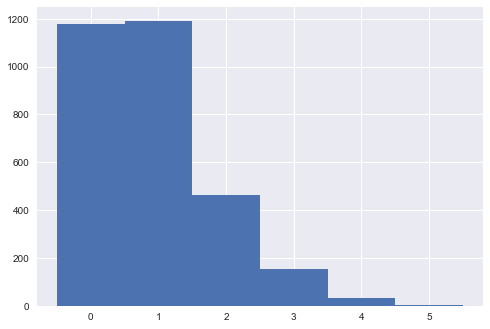

In [29]:
max_reloc = max(analysis_runs.nr_relocations)
print(max_reloc)
plt.hist(analysis_runs.nr_relocations, bins=range(0,max_reloc+2), align='left')


   original_length  nr_relocations
0               37        0.936441
1               41        0.817906
2               43        0.839813
3               46        0.923588


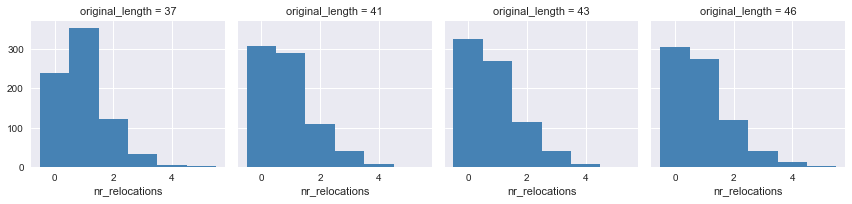

In [30]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.FacetGrid(analysis_runs, col="original_length", margin_titles=True)
bins = range(0,max_reloc+2)
g.map(plt.hist, "nr_relocations", color="steelblue", bins=bins, lw=0, align='left')

print(analysis_runs.loc[analysis_runs.success == 1].groupby('original_length', as_index=False)[['nr_relocations']].mean())

# CODE HAS BEEN RUN UNTILL HERE.
.

.

.

.

.

.

.

.

v






# analysis of mistakes



In [21]:
analysis_runs.loc[analysis_runs.success == 0].sort_values('terminated_at_step')

,instance_id,nr_relocations,original_length,success,terminated_at_step
1511,5511,0,43,0,9
2734,6734,0,46,0,9
2035,6035,0,43,0,9
2407,6407,0,46,0,10
2624,6624,0,46,0,10
2359,6359,0,46,0,10
2303,6303,0,46,0,10
2266,6266,0,46,0,10
2181,6181,0,43,0,10
2169,6169,0,43,0,10


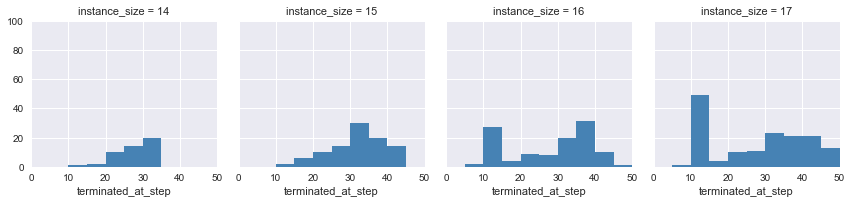

In [45]:
#plt.hist(analysis_runs.loc[analysis_runs.success == 0].terminated_at_step, bins=8)

len(analysis_runs.loc[analysis_runs.success == 0])

analysis_runs['instance_size'] = analysis_runs.apply(lambda row: str(row.original_length).replace('37', '14').replace('41', '15').replace('43', '16').replace('46','17'), axis=1)

import seaborn as sns
sns.set(style="darkgrid")

bins = [0,5,10,15,20,25,30,35,40,45,50]
g = sns.FacetGrid(analysis_runs.loc[analysis_runs.success == 0], col="instance_size", margin_titles=True)
g.set(ylim=(0, 100), xlim=(0,50))

g.map(plt.hist, "terminated_at_step", color="steelblue", bins=bins, lw=0)
sns.plt.savefig('185k_failures.eps')